# Imbalanced Data

**Goal:** To explore features of the dataset, use visualizations to help in understanding those features, and develop a model that solves the problem of imbalanced data nu under- and over-sampling.

In [69]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Import Data

In [70]:
def wrangle(url):
    df = pd.read_csv(url)
    #Re-code the class variable to True = 1, and False = 0:
    df['class'] = df['class'].replace({0: False, 1: True})
    
    #Rename the class variable to bankrupt
    df = df.rename(columns={'class': 'bankrupt'}).set_index("year")

    return df

In [71]:
df = wrangle("https://archive.ics.uci.edu/static/public/365/data.csv")
df.head()

**Important Note**: Class: Whether a company went bankrupt(1) or a company that did not go bankrupt(0)

Explore

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43405 entries, 1 to 5
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   A1        43397 non-null  float64
 1   A2        43397 non-null  float64
 2   A3        43397 non-null  float64
 3   A4        43271 non-null  float64
 4   A5        43316 non-null  float64
 5   A6        43397 non-null  float64
 6   A7        43397 non-null  float64
 7   A8        43311 non-null  float64
 8   A9        43396 non-null  float64
 9   A10       43397 non-null  float64
 10  A11       43361 non-null  float64
 11  A12       43271 non-null  float64
 12  A13       43278 non-null  float64
 13  A14       43397 non-null  float64
 14  A15       43369 non-null  float64
 15  A16       43310 non-null  float64
 16  A17       43311 non-null  float64
 17  A18       43397 non-null  float64
 18  A19       43277 non-null  float64
 19  A20       43278 non-null  float64
 20  A21       37551 non-null  float64
 21

In [ ]:
df.shape

(43405, 65)

In [ ]:
df.head(3)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,bankrupt
year,,,,,,,,,,,,,,,,,,,,,
1,0.20055,0.37951,0.39641,2.0472,32.3510,0.38825,0.24976,1.33050,1.1389,0.50494,...,0.12196,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,False
1,0.20912,0.49988,0.47225,1.9447,14.7860,0.00000,0.25834,0.99601,1.6996,0.49788,...,0.12130,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,False
1,0.24866,0.69592,0.26713,1.5548,-1.1523,0.00000,0.30906,0.43695,1.3090,0.30408,...,0.24114,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,False


Plot Class Balance

In [ ]:
df["bankrupt"].value_counts(normalize=True)

bankrupt
False    0.951826
True     0.048174
Name: proportion, dtype: float64

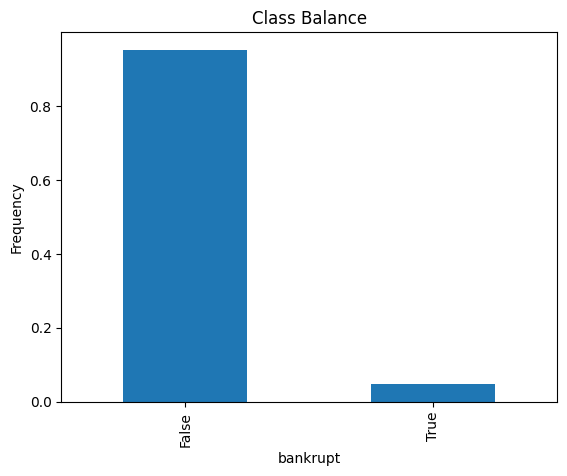

In [ ]:
# Plot class balance
df["bankrupt"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="bankrupt",
    ylabel="Frequency",
    title="Class Balance"
);

- Positive Class: True

- Negative class: False

Feature Box Plot: Feature A27

- A7: profit on operating activities/ expenses

ValueError: cannot reindex on an axis with duplicate labels

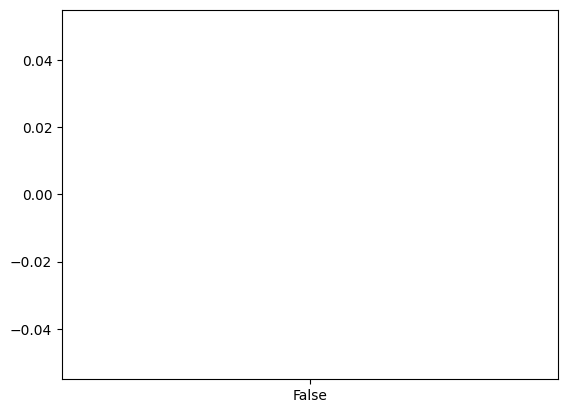

In [ ]:
sns.boxplot(x="bankrupt",y="A27", data=df)
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

Observation:
- Companies that did not go bankrupt seem to have larger values of profit to expenses ratio.

- Companies that went bankrupt seem to have smaller profit to expenses ratio.

Genearrly, the results suggests that if a company is spending more than what it earns as profit, then that might be an indicator for bankruptcy while companies that makes lots of proft has the potential of not gong bankrupt.

#### Feature summary statistcs - A27

In [ ]:
df.A27.describe().apply("{0:,.0f}".format)

count       40,641
mean         1,108
std         35,015
min       -259,000
25%              0
50%              1
75%              5
max      4,210,000
Name: A27, dtype: object

- The median (50%) is 1, implying that comapies that are below 1 are those that have higher expenses that profits. On the contrary, companies that are above 1 are those that are profitable - higher profits than expenses.

- The middle 50% (between 25% quartile and 75% quartile) are those between 0 and 5. This is where most of the observations are falling.

- The minimum is -259,000 implying that the company is making losses.

- Maximum is 4, 210, 000 suggesting that the company is making a lot of profits. 

- Overal, the observations means that the data has a skewed distribution.
- Now, given the median is 1, and the mean is is 1, 108 suggests that the large datasets are pulling the mean towrds the large posittive observatins.
- The next task involves plotting the distribution of the feature.




#### Feature Histogram

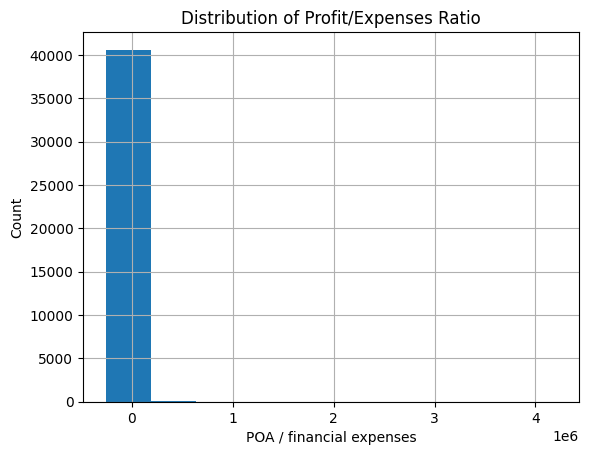

In [ ]:
df["A27"].hist()
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio");

#### Clipped Feature Histogram

In [ ]:

Q1, Q9 = df["A27"].quantile([.1, .9])
mask = df["A27"].between(Q1, Q9)
mask.head()

year
1     True
1    False
1    False
1     True
1     True
Name: A27, dtype: bool

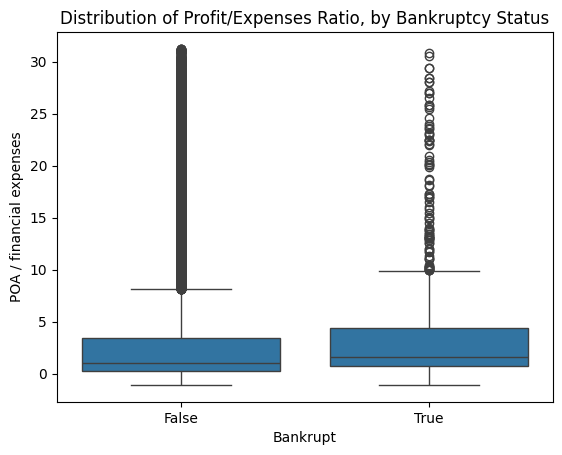

In [ ]:
Q1, Q9 = df["A27"].quantile([.1, .9])
mask = df["A27"].between(Q1, Q9)
sns.boxplot(x="bankrupt", y="A27", data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

Correlation HeatMap

In [ ]:
corr = df.drop(columns="bankrupt").corr()
corr.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
A1,1.000000,-0.104146,0.058037,0.000855,0.002744,0.315139,0.408428,0.000184,-0.225720,-0.240254,...,0.004015,0.000044,0.007764,-0.000302,-0.000220,0.000213,0.000582,0.000321,0.008387,-0.069021
A2,-0.104146,1.000000,-0.926983,-0.001589,-0.036322,-0.842916,0.102020,-0.002385,-0.016594,-0.409341,...,-0.009580,-0.000235,-0.000793,0.000270,0.000617,-0.000078,-0.001191,0.046769,-0.003339,-0.015647
A3,0.058037,-0.926983,1.000000,0.002335,0.038877,0.760215,0.033521,0.001267,-0.002981,0.369558,...,0.011102,0.000017,0.000779,-0.000034,-0.000247,0.000377,-0.000139,-0.050052,0.004044,-0.000910
A4,0.000855,-0.001589,0.002335,1.000000,0.001852,0.000050,0.000167,0.598635,-0.000392,0.001668,...,-0.000077,0.000281,0.000125,-0.000289,-0.000266,0.001670,0.004387,-0.000704,0.039447,0.000122
A5,0.002744,-0.036322,0.038877,0.001852,1.000000,0.029288,0.001492,0.001631,0.000796,0.014701,...,0.001536,-0.000031,-0.000009,0.000029,0.000067,0.000087,0.000007,-0.002635,0.000690,0.000198


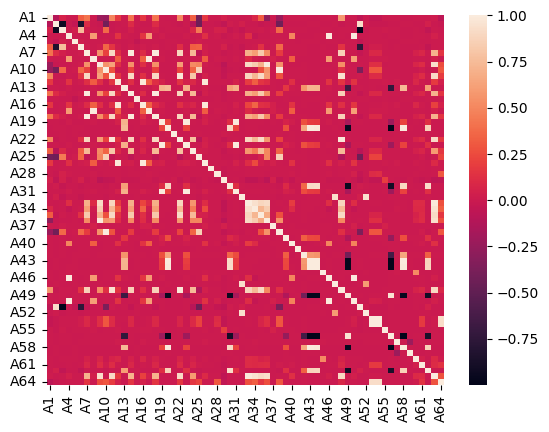

In [ ]:
sns.heatmap(corr);

#### Split